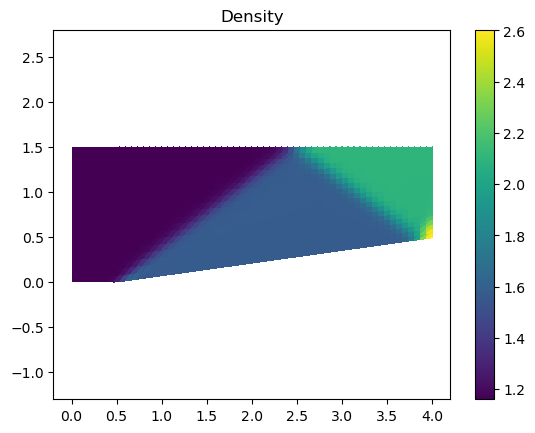

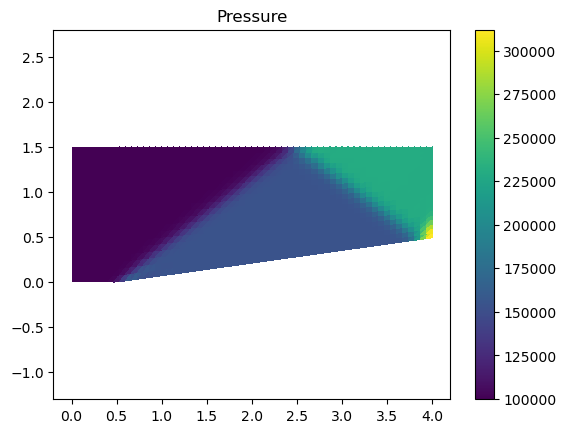

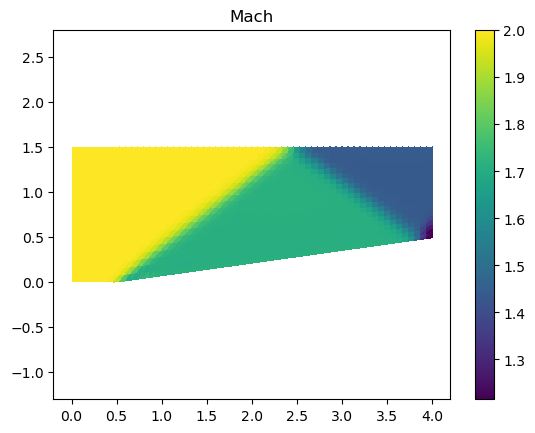

("Residual = ", res, " Relative resiual = ", res / res0, "; ite/MAXITE = ", istep, "/", MAXITE) = ("Residual = ", 4.197751636422293, " Relative resiual = ", 1.421968319435129e-7, "; ite/MAXITE = ", 1000, "/", 1000)


PyObject Text(0.5, 1.0, 'Mach')

In [5]:
using Revise
using PyPlot
using JLD2
using LinearAlgebra
using FluidSolver


cnx, cny = 60, 20     # cells
nx, ny = cnx+1, cny+1 # points
θ = 8.0*pi/180.0      # wedge angle

# Construct uniform grid
x = LinRange(0,4,nx);
y = LinRange(0,1.5,ny);


xx = zeros(Float64, nx,ny)
yy = zeros(Float64, nx,ny)
for i=1:nx
    for j=1:ny
        xx[i,j] = x[i];
        yy[i,j] = y[j];
    end
end

# Deform grid to account for ramp
y_ffb = 1.5;
for i=1:nx
    if (xx[i,1] >= 0.5)
        yy[i,1] = yy[i,1] + (xx[i,1] - 0.5) * tan(θ);
    end
end
for i=1:nx
    dy = yy[i,1];
    for j=2:ny
        ratio = 1 - (yy[i,j]) / y_ffb;
        deformation = dy * ratio;
        yy[i,j] = yy[i,j] + deformation;
    end
end



# Generate mesh node coordinates
xys = zeros(Float64, 2 , nx * ny)
for j = 1:ny
    for i = 1:nx
        xys[:, i + (j - 1) * nx] .= xx[i,j], yy[i,j]
    end
end

# Generate element list
elems = zeros(Int64, 4, cnx * cny)
for j = 1:cny
    for i = 1:cnx
        # i +   j*nx  , i+1 +  j*nx
        # i + (j-1)*nx, i+1 + (j-1)*nx
        elems[:, (i - 1)+(j - 1)*cnx + 1] .= i+1+j*nx,  i+j*nx,  i+(j-1)*nx,  i+1+(j-1)*nx
    end
end

# Generate boundary map, e1, e2, bc_type, bc_date_typ
bc_map = zeros(Int64, 4,  2 * (nx - 1 + ny - 1))
ibc = 1
for i = 1:nx - 1
    global ibc
    bc_map[:, ibc] .= i, i + 1, 1, 1 # bottom wall
    ibc += 1
    bc_map[:, ibc] .= i + (ny - 1) * nx, i + 1 + (ny - 1) * nx, 1, 1 # top wall
    ibc += 1
end

for j = 1:ny - 1
    global ibc
    bc_map[:, ibc] .= 1 + (j - 1) * nx, 1 + j * nx, 2, 1 # left farfield wall
    ibc += 1
    bc_map[:, ibc] .= nx + (j - 1) * nx, nx + j * nx, 2, 2 # right farfield wall
    ibc += 1
end

# Generate far-field boundary conditions
gamma = 1.4

p_oo = 10.0^5; T_oo = 300.0; M_oo = 2.0; R = 287.0
rho_oo = p_oo/(R*T_oo); u_oo = M_oo*sqrt(gamma*p_oo/rho_oo); v_oo = 0.;



W_oo = zeros(Float64, 4, 2)
W_oo[:, 1] .= Prim_To_Conser([rho_oo, u_oo, v_oo, p_oo], gamma)
W_oo[:, 2] .= Prim_To_Conser([rho_oo, u_oo, v_oo, p_oo], gamma)


bc_data = [Array{Float64}(undef, 0, 0), W_oo]

# Generate mesh object
mesh = QuadMesh(xys, elems, bc_map, bc_data)



# Generate solver
cfl_init = 0.8
cfl_max = 0.8
eps1 = 1.0e-7
maxite = 1000

input = Input(problem_type = "Steady", max_iteration = maxite, converge_eps = eps1,
              time_integrator = "RK2", time_step_computation = "Local_CFL", 
              cfl_init_number = cfl_init, cfl_max_number = cfl_max, 
              limiter_type = "Minmod", limiter_beta = 1.0/3.0,
              gamma = gamma)


solver = NSSolver(mesh, input)
# Generate initial conditions
W0 = zeros(Float64, 4, nx * ny)

for i = 1:nx * ny
    W0[:, i] = W_oo[:, 1]
end

W = Solve!(solver,  W0, input)


# Postprocess
V = zeros(Float64, 4, nx * ny)
Conser_To_Prim!(W, V, gamma)
M = sqrt.(V[2, :].^2 + V[3, :].^2)./sqrt.(gamma*V[4, :]./V[1, :])

# Plot results
fig=figure()
Visual_Tripcolor(mesh, V[1, :])
title("Density")

fig=figure()
Visual_Tripcolor(mesh, V[4, :])
title("Pressure")

fig=figure()
Visual_Tripcolor(mesh, M)
title("Mach")

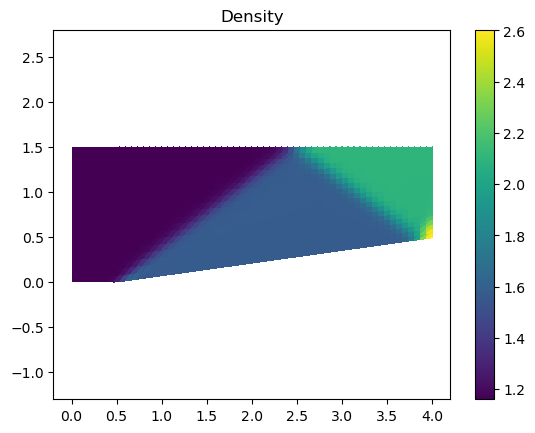

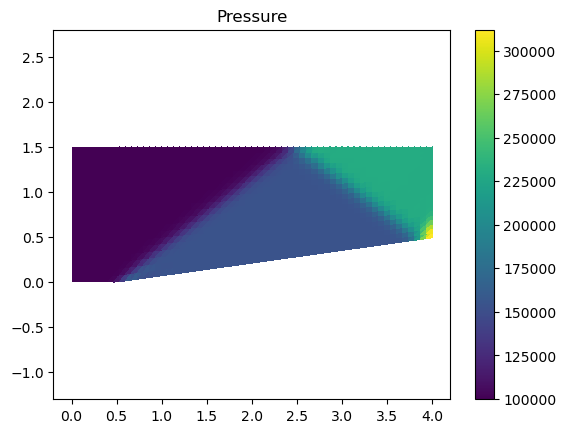

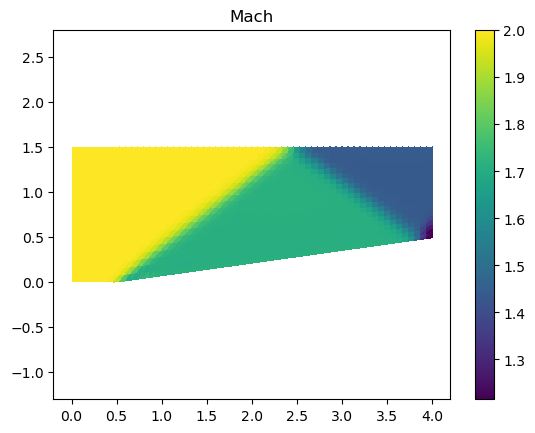

PyObject Text(0.5, 1.0, 'Mach')